# Проект: классификация

In [823]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, f_regression
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [824]:
# Загружаем исходные данные:
data = pd.read_csv('Data/bank_fin.csv', sep = ';')
# Выводим на экран данные:
data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [825]:
# Исследуйте данные на предмет пропусков.
# Где есть пропущенные значения? Сколько их?

data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [826]:
# Есть ли в признаке job пропущенные значения?
# Возможно, они обозначены каким-то специальным словом?

print(data['job'].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [827]:
# Преобразуйте признак balance таким образом, чтобы
# он корректно считывался, как вещественное число (float):

data['balance'] = data['balance'].astype(str)

data['balance']  = data['balance'].apply(
    lambda x: str(x.replace("$","").replace(" ", "").split(',')[0]))
data['balance'] = data['balance'].astype(float)
print(round(data['balance'].mean(), 3))

data.head(5)

1529.129


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Задание 4

In [828]:
# Обработайте пропуски в признаки balance,
# заменив их на медианные значения по данному признаку:

data['balance'].fillna(data['balance'].median(), inplace=True)
print(round(data['balance'].mean(), 3))

1526.936


### Задание 5

In [829]:
# Обработайте пропуски в категориальных признаках
# job и education, заменив их на модальные значения:

mode_job = data['job'].mode()
mode_ed = data['education'].mode()

data['job'] = data['job'].replace('unknown', 'management')
data['education'] = data['education'].replace('unknown', 'secondary')

av_balance = data[(data['job'] == 'management') 
                  & (data['education'] == 'secondary')]['balance'].mean()
print(round(av_balance, 3))

1598.883


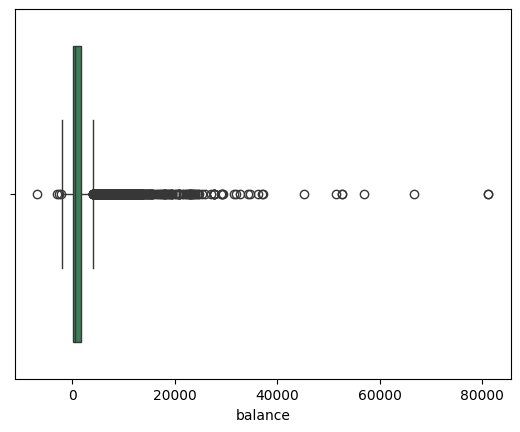

In [830]:
# Построим график:

sns.boxplot(
    data = data,
    x = 'balance',
    orient = 'h',
    color = 'seagreen'
)

# Выводим результат на экран:            
plt.show()

### Задание 6

In [831]:
# удалите все выбросы для признака balance:

display(data['balance'].describe())

count    11162.000000
mean      1526.936033
std       3224.829691
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1699.000000
max      81204.000000
Name: balance, dtype: float64

In [832]:
# Вычисление границ IQR:

Q1, Q3 = data['balance'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
print(lower_bound, upper_bound)

# Отсеивание выбросов:

data = data[(data['balance'] >= lower_bound) & (data['balance'] <= upper_bound)]

-2241.0 4063.0


In [833]:
display(data['balance'].describe())

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

## Часть 2:  Разведывательный анализ

### Задание 1

In [834]:
# Изучите соотношение классов в ваших данных
# на предмет несбалансированности,
# проиллюстрируйте результат:

data['age'].max()
data['job'].value_counts()
display(data['deposit'].describe())
data['deposit'].value_counts()

count     10105
unique        2
top          no
freq       5424
Name: deposit, dtype: object

deposit
no     5424
yes    4681
Name: count, dtype: int64

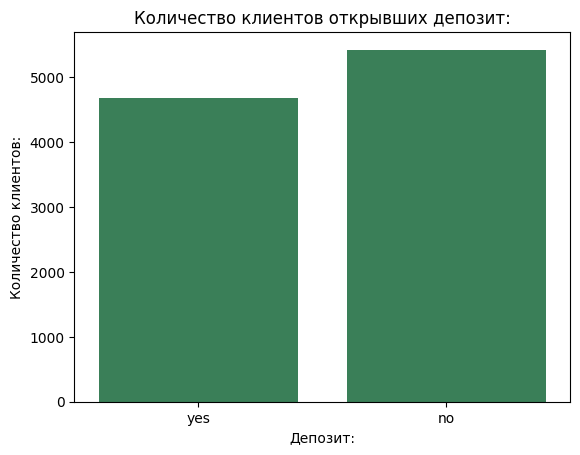

In [835]:
# Построим график:

sns.countplot(data = data,
              x =  'deposit',
              orient = 'h',
              color = 'seagreen',
              stat = 'count',
              legend = 'auto')

# Настройка заголовков осей координат:
plt.xlabel('Депозит:')
plt.ylabel('Количество клиентов:')
# Настройка заголовка и отображение графика:
plt.title('Количество клиентов открывших депозит:')
plt.show()

### Задания 2 и 3

In [836]:
# Рассчитайте описательные статистики для количественных переменных,
# проинтерпретируйте результат:

data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [837]:
# Рассчитайте описательные статистики для категориальных переменных,
# проинтерпретируйте результат:

data.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


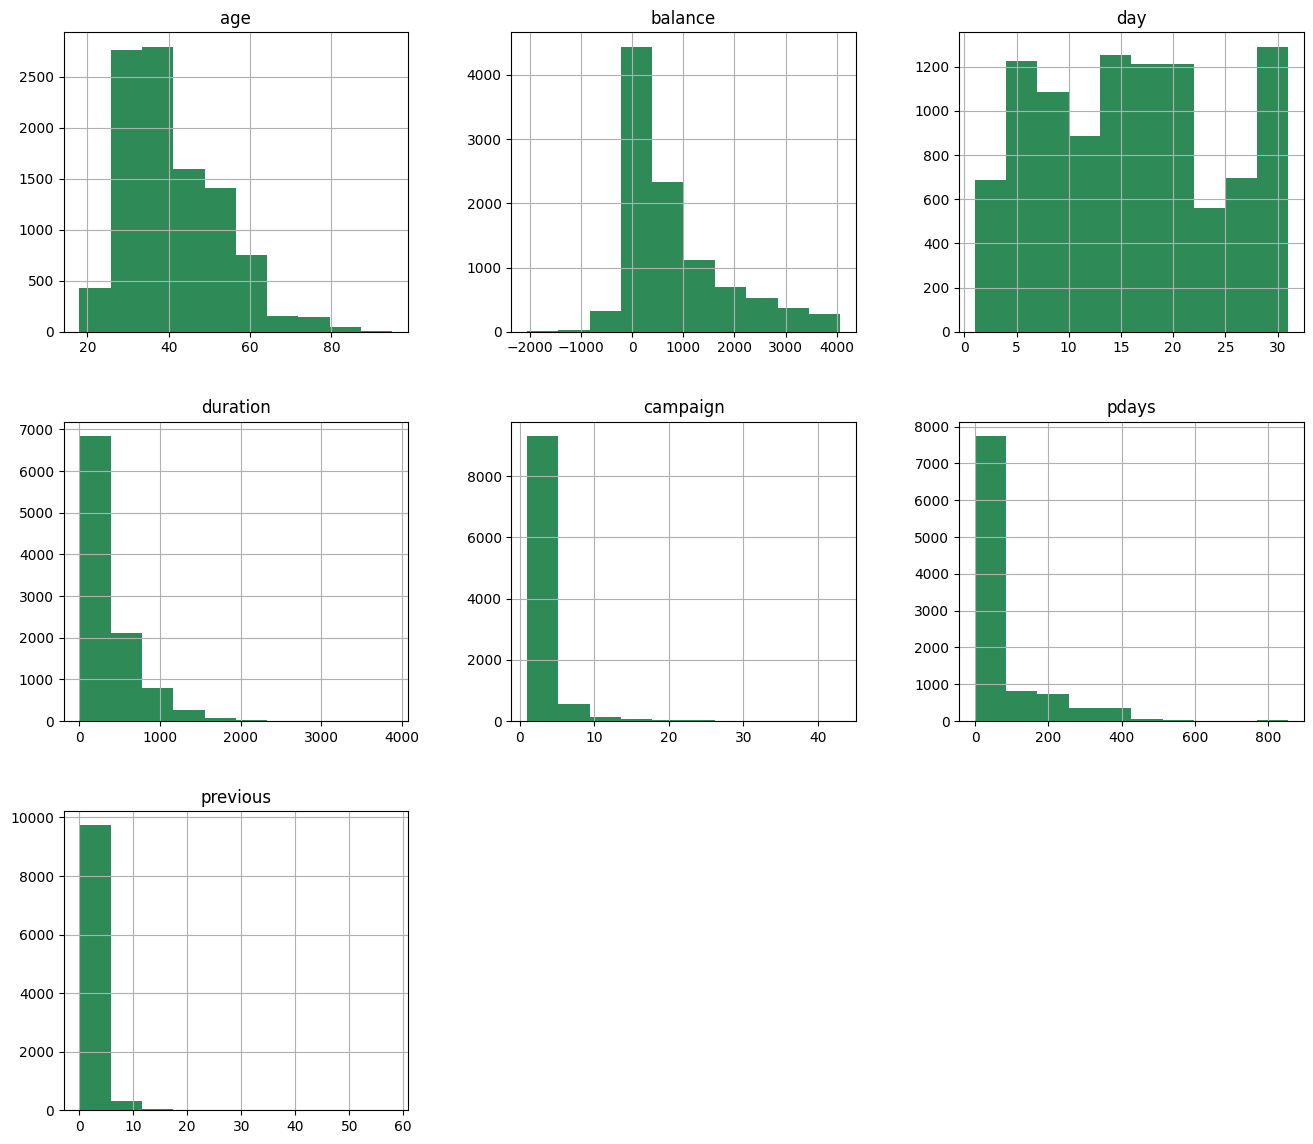

In [838]:
# Постройте визуализации, иллюстрирующие результаты:

data.hist(figsize = (16,14),
          # Цвет графика:
          color = ['seagreen'])

# Выводим результат на экран:
plt.show()

### Задание 6

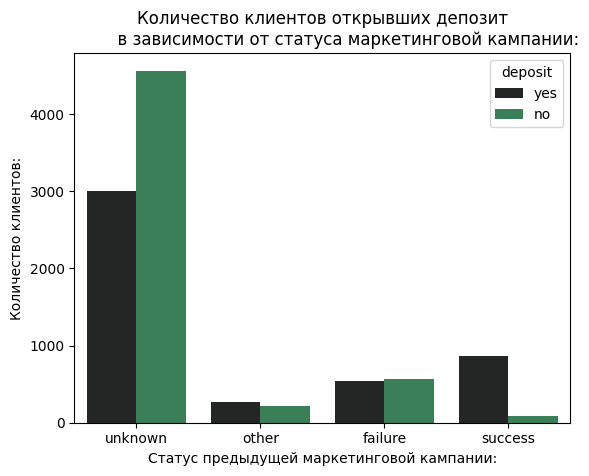

In [839]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании
# успех в текущей превалирует над количеством неудач.

# Построим график:

sns.countplot(data = data,
              x = 'poutcome',
              hue = 'deposit',
              orient = 'h',
              color = 'seagreen',
              stat = 'count',
              legend = 'auto')

# Настройка заголовков осей координат:
plt.xlabel('Cтатус предыдущей маркетинговой кампании:')
plt.ylabel('Количество клиентов:')
# Настройка заголовка и отображение графика:
plt.title('''Количество клиентов открывших депозит
          в зависимости от статуса маркетинговой кампании:''')
plt.show()

### Задание 7

In [840]:
# Узнайте, в каком месяце чаще всего отказывались
# от предложения открыть депозит:

data['month'].value_counts()

month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64

### Задание 8

In [841]:
# Создайте возрастные группы и определите, в каких группах более
# склонны открывать депозит, чем отказываться от предложения:

data['AgeCategory'] = pd.cut(data['age'], (0, 30, 40, 50, 60, 9999),
                             labels = ['<30', '30-40', '40-50', '50-60', '60+'])

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,AgeCategory
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


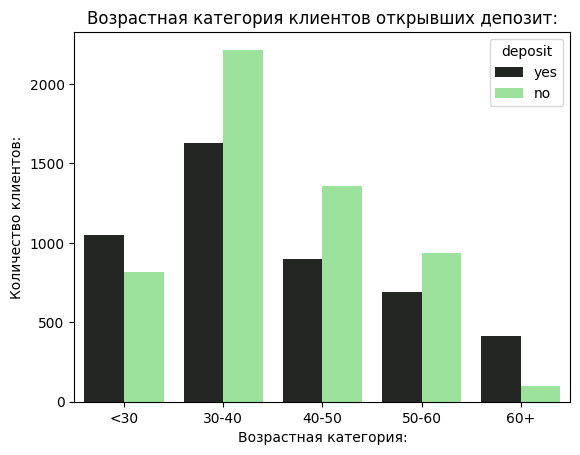

In [842]:
# Построим график:

sns.countplot(data = data,
              x = 'AgeCategory', hue = 'deposit',
              orient = 'h',
              color = 'lightgreen',
              stat = 'count',
              legend = 'auto')

# Настройка заголовков осей координат:
plt.xlabel('Возрастная категория:')
plt.ylabel('Количество клиентов:')
# Настройка заголовка и отображение графика:
plt.title('''Возрастная категория клиентов открывших депозит:''')
plt.show()

### Задания 9 и 10

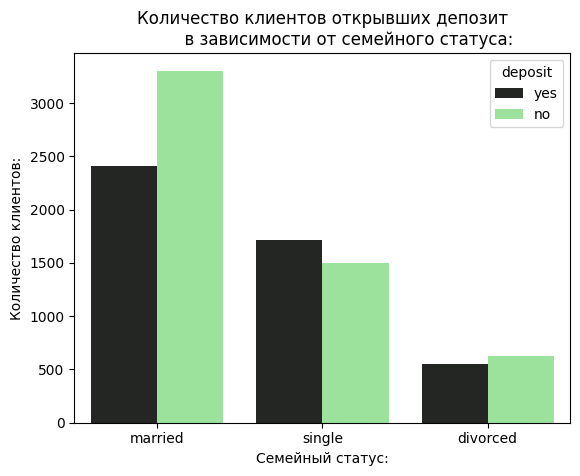

In [843]:
# Постройте визуализации для открывших и неоткрывших депозит
# в зависимости от семейного статуса:

data.groupby('deposit')['marital'].value_counts()

sns.countplot(data = data,
              x = 'marital', hue = 'deposit',
              orient = 'h', color = 'lightgreen',
              stat = 'count',
              legend = 'auto')

# Настройка заголовков осей координат:
plt.xlabel('Cемейный статус:')
plt.ylabel('Количество клиентов:')
# Настройка заголовка и отображение графика:
plt.title('''Количество клиентов открывших депозит
          в зависимости от семейного статуса:''')
plt.show()

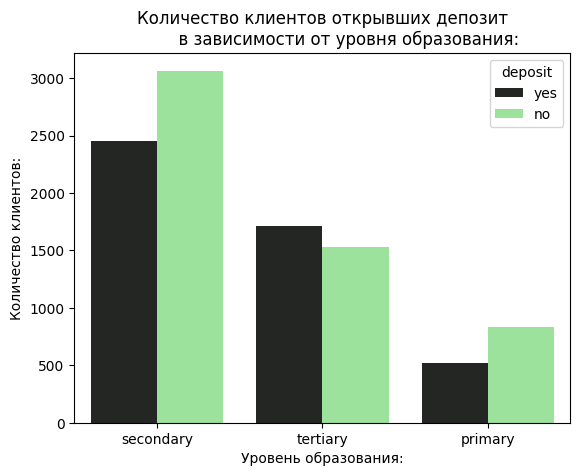

In [844]:
# постройте визуализации для открывших и неоткрывших депозит
# в зависимости от образования:

data.groupby('deposit')['education'].value_counts()

sns.countplot(data = data,
              x = 'education', hue = 'deposit',
              orient = 'h', color = 'lightgreen',
              stat = 'count',
              legend = 'auto')

# Настройка заголовков осей координат:
plt.xlabel('Уровень образования:')
plt.ylabel('Количество клиентов:')
# Настройка заголовка и отображение графика:
plt.title('''Количество клиентов открывших депозит
          в зависимости от уровня образования:''')
plt.show()

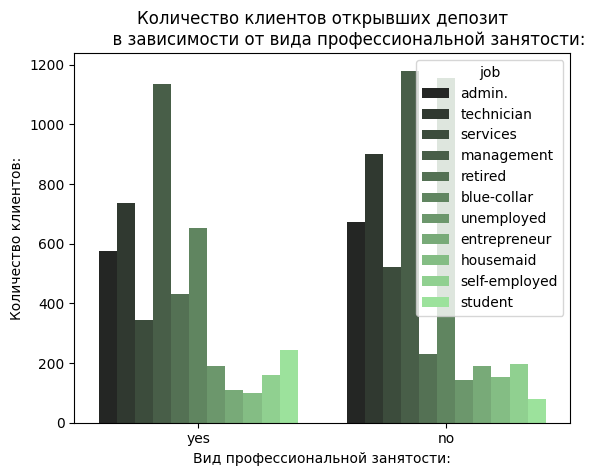

In [845]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости
# от вида профессиональной занятости:

data.groupby('deposit')['job'].value_counts()

sns.countplot(data = data,
              x = 'deposit', hue = 'job',
              orient = 'h', color = 'lightgreen',
              stat = 'count',
              legend = 'auto')

# Настройка заголовков осей координат:
plt.xlabel('Вид профессиональной занятости:')
plt.ylabel('Количество клиентов:')
# Настройка заголовка и отображение графика:
plt.title('''Количество клиентов открывших депозит
          в зависимости от вида профессиональной занятости:''')
plt.show()

### Задание 11

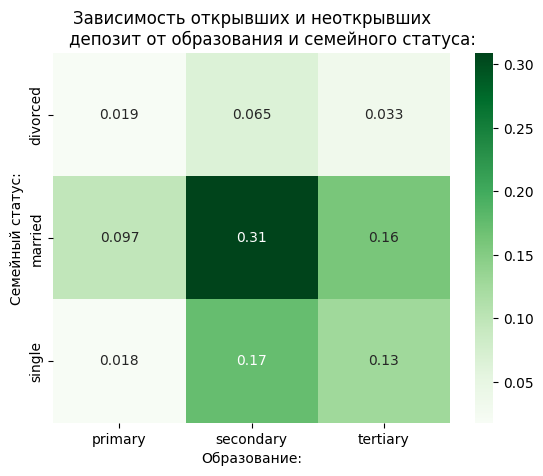

In [846]:
# Создаем кросстаблицу:

crosstable = pd.crosstab(
    data['marital'], data['education'], values=data['deposit'],
    aggfunc="count", normalize=True
)

heatmap = sns.heatmap(data = crosstable, annot = True, cmap = 'Greens')

# Настройка заголовков осей координат:
heatmap.set(xlabel = 'Образование:', ylabel = 'Семейный статус:')
# Настройка заголовка и отображение графика:
heatmap.set_title('''Зависимость открывших и неоткрывших
        депозит от образования и семейного статуса:''')
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [847]:
# Преобразуйте уровни образования:

labelencoder = LabelEncoder()

data['education'] = labelencoder.fit_transform(data['education'])
data['education'].sum()

11995

### Задания 2 и 3

In [848]:
# Преобразуйте бинарные переменные в представление из нулей и единиц:
# Кодируем признак 'deposit':

data['deposit'] = data['deposit'].map({"yes": 1, "no": 0})
print(round(data['deposit'].std(),3))

0.499


In [849]:
# Кодируем признак 'default':

data['default'] = data['default'].map({"yes": 1, "no": 0})
print(round(data['default'].mean(),3))

0.016


In [850]:
# Кодируем признак 'housing':

data['housing'] = data['housing'].map({"yes": 1, "no": 0})
print(round(data['housing'].mean(),3))

0.481


In [851]:
# Кодируем признак 'loan':

data['loan'] = data['loan'].map({"yes": 1, "no": 0})
print(round(data['loan'].mean(),3))

0.138


### Задание 4

In [852]:
# Cоздайте дамми-переменные:
# Кодируем признаки методом OneHotEncoding:

data = pd.get_dummies(data, columns = ['job', 'marital', 'contact', 'month', 'poutcome'],
                      dtype = int)
data.shape

(10105, 46)

### Задания 5 и 6

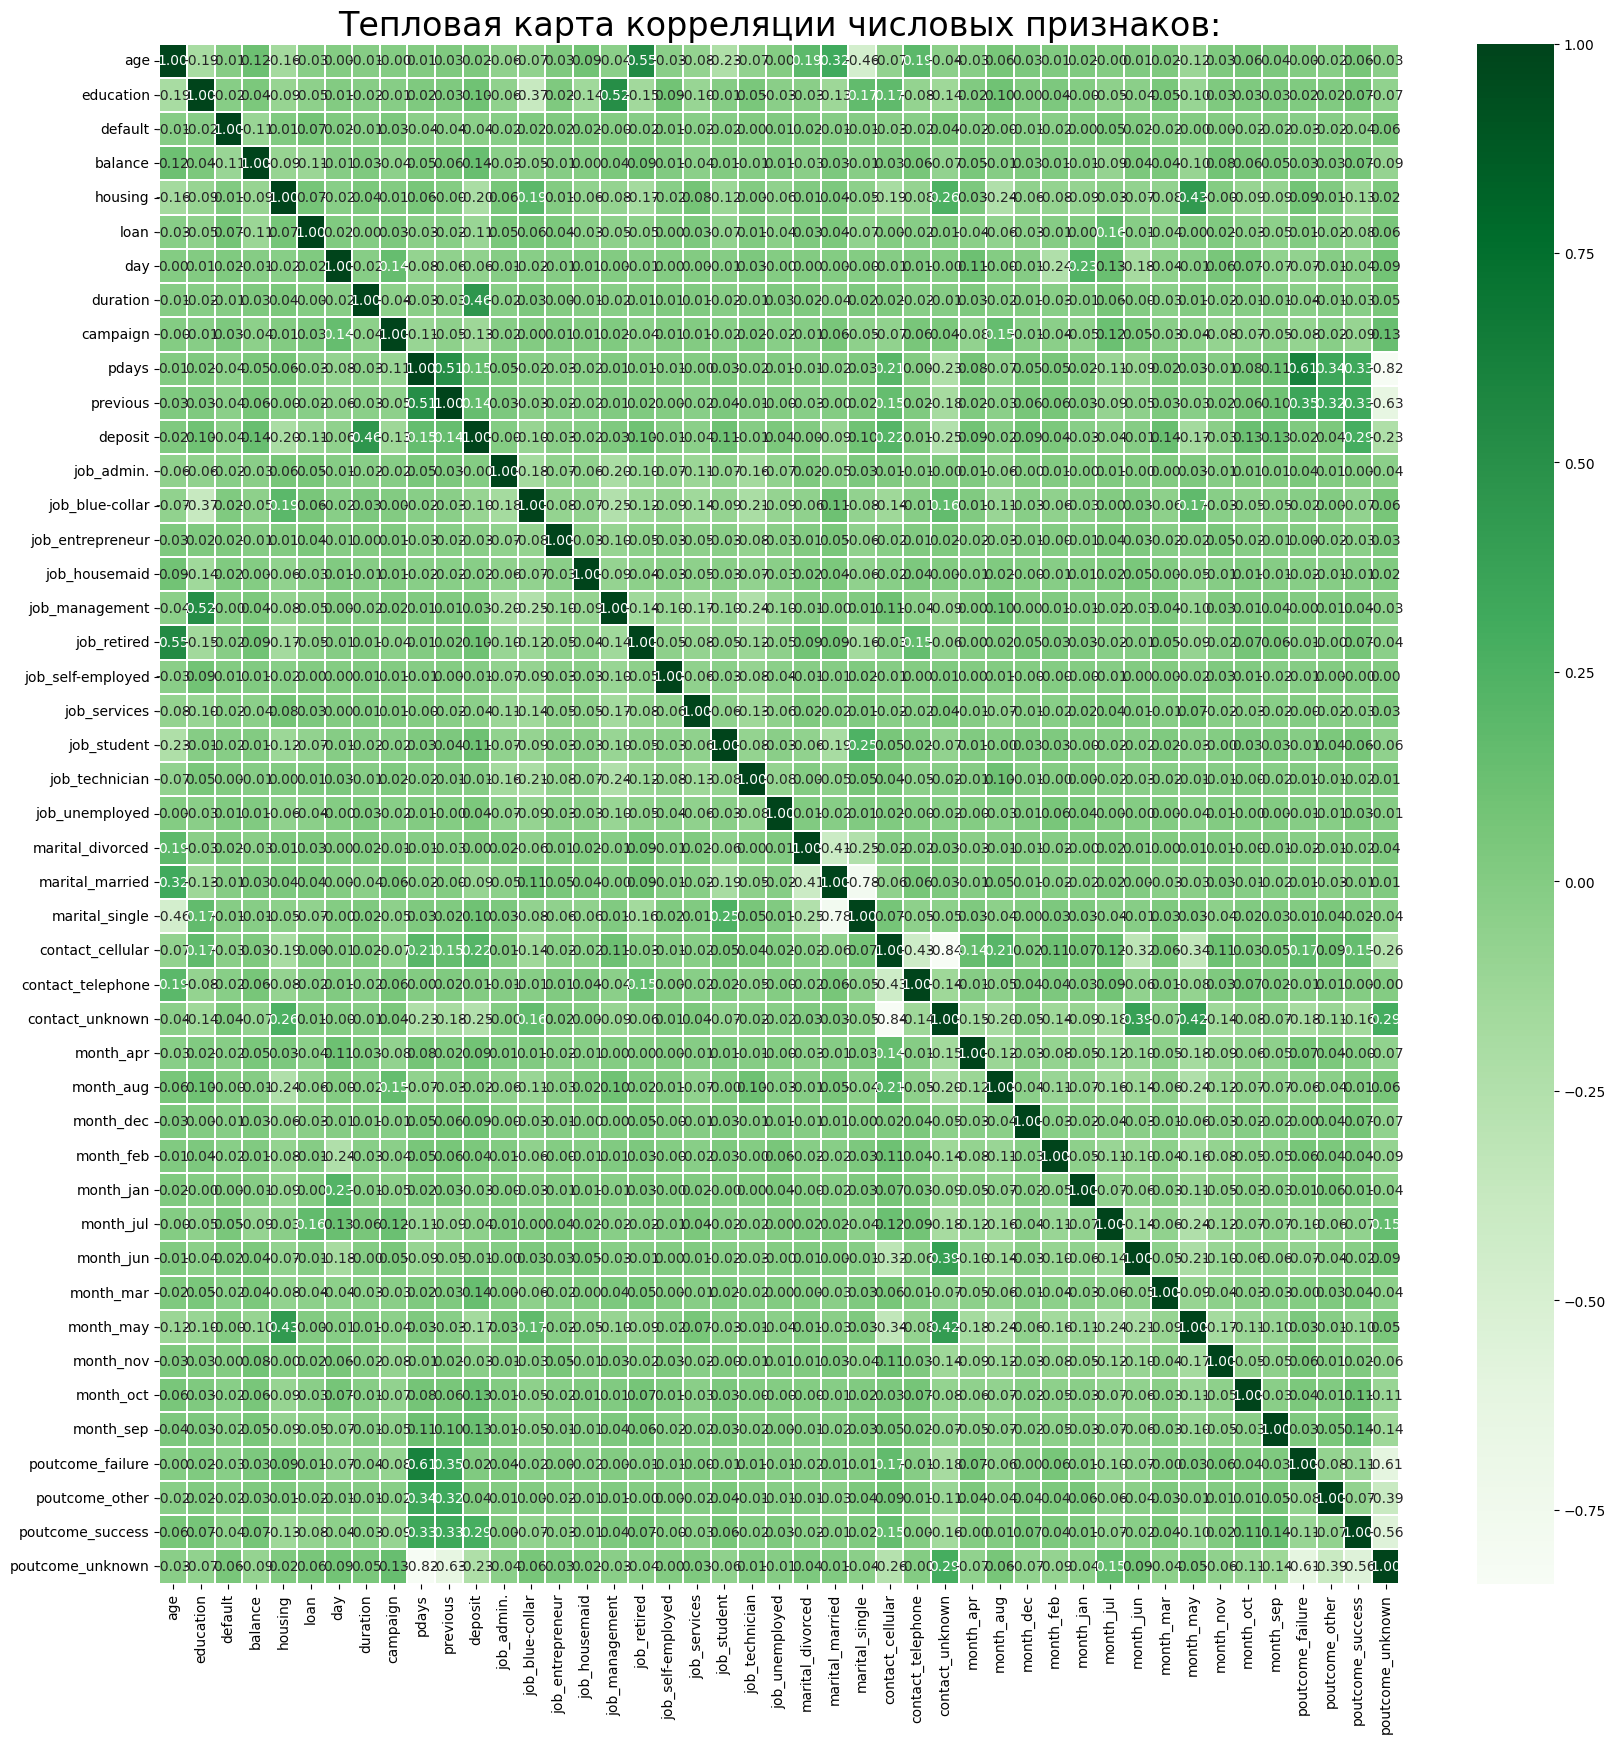

In [853]:
# Постройте корреляционную матрицу и оцените данные
# на предмет наличия мультиколлинеарности:

object_columns = [s for s in data.columns if data[s].dtypes == 'category']
data.drop(object_columns, axis = 1, inplace=True)

fig = plt.figure(figsize = (20,20))
heatmap = sns.heatmap(data.corr(),
                      fmt='.2f', linewidths=.1,
                      annot = True, cmap = 'Greens')

# Настройка заголовка и отображение графика:
heatmap.set_title('''Тепловая карта корреляции числовых признаков:''', fontsize = 24)
plt.show()

### Задания 7 и 8

In [854]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, random_state = 42,
                                                    test_size = 0.33)

In [855]:
# рассчитайте необходимые показатели:

print('Test shape: {}'.format(X_test.shape))
print('Train shape: {}'.format(X_train.shape))

print(round(y_test.mean(),2))

Test shape: (3335, 44)
Train shape: (6770, 44)
0.46


### Задание 9

In [856]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков:

selector = SelectKBest(f_classif, k=15)
selector.fit(X, y)
selector.fit(X_train, y_train)
X.columns[selector.get_support(indices=True)].tolist()

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [857]:
# нормализуйте данные с помощью minmaxsxaler:

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

# Масштабируем признаки обучающей выборки:
X_train_scaled = scaler.transform(X_train)

# Преобразуем тестовые данные рассчитанных на обучающей выборке:
X_test_scaled = scaler.transform(X_test)

print(round(X_test_scaled[:,0].mean(),2))

0.31


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [858]:
# обучите логистическую регрессию и рассчитайте метрики качества:
# Создаем объект класса логистическая регрессия:

log_reg = linear_model.LogisticRegression(
    solver = 'sag',
    # Генератор случайных чисел:
    random_state = 42,
    # Количество итераций на сходимость:
    max_iter = 1000
)
# Обучаем модель, минимизируя logloss:
log_reg.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = log_reg.predict(X_train_scaled)

# Делаем предсказание для тестовой выборки:
y_test_pred = log_reg.predict(X_test_scaled)

# Выводим значение метрики:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1790
           1       0.82      0.77      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [859]:
# обучите решающие деревья, настройте максимальную глубину:
# Создаём объект класса DecisionTreeClassifier:

dt = tree.DecisionTreeClassifier(
    # Критерий информативности:
    criterion = 'entropy',
    # Генератор случайных чисел:
    random_state = 42,
    max_depth = 6
)
# Обучаем дерево решений по алгоритму CART:
dt.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = dt.predict(X_train_scaled)

# Делаем предсказание для тестовой выборки:
y_test_pred = dt.predict(X_test_scaled)

# Выводим значение метрики:
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      3634
           1       0.79      0.82      0.80      3136

    accuracy                           0.81      6770
   macro avg       0.81      0.81      0.81      6770
weighted avg       0.82      0.81      0.81      6770



### Задание 5

In [860]:
# подберите оптимальные параметры с помощью gridsearch:

# Настройка Grid Search:
parameters = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search = GridSearchCV(tree.DecisionTreeClassifier(),
                           parameters,                       
                           cv = 5, scoring = ('f1'),
                           return_train_score = True)

# Обучение модели:
grid_search.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = grid_search.predict(X_train_scaled)

# Делаем предсказание для тестовой выборки:
y_test_pred = grid_search.predict(X_test_scaled)

# Выводим значение метрики:
print(metrics.classification_report(y_test, y_test_pred))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1790
           1       0.79      0.84      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [861]:
# обучите на ваших данных случайный лес:
# Создаем объект класса случайный лес:

rf = ensemble.RandomForestClassifier(
    # Число деревьев:
    n_estimators = 100,
    # Критерий эффективности:
    criterion = 'gini',
    # Максимальная глубина дерева:
    max_depth = 10,
    # Минимальное число объектов в листе:    
    min_samples_leaf = 5,
    # Генератор случайных чисел:
    random_state = 42
)
# Обучаем модель:
rf.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = rf.predict(X_train_scaled)

# Делаем предсказание для тестовой выборки:
y_test_pred = rf.predict(X_test_scaled)

# Выводим значение метрики:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### Задания 2 и 3

In [862]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом:
# Создаем объект класса градиентный бустинг

gb = GradientBoostingRegressor(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

# Обучаем модель:
gb.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = gb.predict(X_train_scaled)

# # Выводим значение метрики:
# # print(metrics.classification_report(y_train, y_train_pred))

# Делаем предсказание для тестовой выборки:
y_test_pred = gb.predict(X_test_scaled)

# Выводим значение метрики:
# print(metrics.classification_report(y_test, y_test_pred))

### Задание 4

In [863]:
# объедините уже известные вам алгоритмы с помощью стекинга:
# Создаем список кортежей вида: (наименование модели, модель)

estimators = [
    ('log_reg', linear_model.LogisticRegression(
    solver = 'sag',
    random_state = 42)),
    
    ('dt',  tree.DecisionTreeClassifier(
        criterion = 'entropy',
        random_state = 42,
        min_samples_leaf = 5,
        max_depth = 6)),
    
    ('gb', GradientBoostingRegressor(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42))
]

# Обучаем модель с помощью метода fit(),
# делаем предсказание классов с помощью метода predict(),
# а затем считаем метрики:

# Создаем объект класса стекинг:
stack = ensemble.StackingRegressor(
    # базовые модели в стекинге:
    estimators,
    # датчик генератора случайных чисел:
    final_estimator = linear_model.LogisticRegression(
        random_state = 42 
    )
)
# Обучаем модель:
stack.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = stack.predict(X_train_scaled)

# Выводим значение метрики:
# print(metrics.classification_report(y_train, y_train_pred))

# Делаем предсказание для тестовой выборки:
y_test_pred = stack.predict(X_test_scaled)

# Выводим значение метрики:
# print(metrics.classification_report(y_test, y_test_pred))

ValueError: The estimator LogisticRegression should be a regressor.

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators = trial.suggest_int('n_estimators', 100, 200, 1),
                                          max_depth = trial.suggest_int('max_depth', 10, 30, 1),
                                          min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1))
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2025-04-23 22:44:11,349] A new study created in memory with name: RandomForestClassifier


[I 2025-04-23 22:44:12,679] Trial 0 finished with value: 0.9474178403755869 and parameters: {'n_estimators': 139, 'max_depth': 19, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9474178403755869.
[I 2025-04-23 22:44:14,053] Trial 1 finished with value: 0.9123567668008672 and parameters: {'n_estimators': 159, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9474178403755869.
[I 2025-04-23 22:44:14,716] Trial 2 finished with value: 0.8626227974426945 and parameters: {'n_estimators': 104, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9474178403755869.
[I 2025-04-23 22:44:16,103] Trial 3 finished with value: 0.8900555898702903 and parameters: {'n_estimators': 173, 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9474178403755869.
[I 2025-04-23 22:44:16,994] Trial 4 finished with value: 0.8816376789287363 and parameters: {'n_estimators': 116, 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.947

Наилучшие значения гиперпараметров {'n_estimators': 136, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.96
accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.85


In [ ]:
optuna.visualization.is_available()
optuna.visualization.plot_optimization_history(study, target_name="f1_score")